<a href="https://colab.research.google.com/github/SovetovAleksey/PyTorch/blob/main/HW_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Обучить генератор создавать точки, которые будут лежать на графике функции
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import IPython.display as display

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

In [ ]:
def _sin(x):
    return np.sin(x) / x - x / 10

In [ ]:
x = np.linspace(-15, 15, 200000)
y = _sin(x)

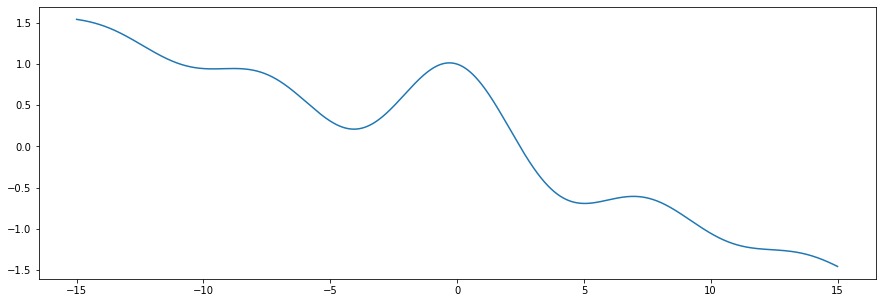

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(x, y)
plt.show()

In [ ]:
df = pd.DataFrame(list(zip(x, y)), columns=['x', 'y'])
df.head(3)

,x,y
0,-15.00000,1.543353
1,-14.99985,1.543346
2,-14.99970,1.543339


In [ ]:
# класс датасета
class MyOwnClass(torch.utils.data.Dataset):

    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        point = self._data[idx]

        return point

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])

        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
             nn.Linear(1024, 2),
             nn.Linear(2, 2),
             nn.Tanh()
        )

    def forward(self, z):
        new_point = self.model(z)
        new_point = new_point.reshape(-1, 2)
        return new_point

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005)
        nn.init.uniform_(self.bias, -0.005, 0.005)

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid()
        )


    def forward(self, img):
        img_flat = img
        validity = self.model(img_flat)
        return validity

In [ ]:
n_epochs = 20  # количество эпох
lr = 0.001  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 100  # количество итераций для отображения процесса обучения

batch_size = 256

In [ ]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
data_train = torch.FloatTensor(df).float()

train_dataset = MyOwnClass(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [ ]:
generator = Generator()
discriminator = Discriminator()

# опитимизатор для каждой сети
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# функция ошибки
adversarial_loss = torch.nn.BCELoss()

In [ ]:
d_loss_history = []
g_loss_history = []

[Epoch 19/20] [Batch 761/781]|[D loss: 0.6823429465293884] [G loss: 0.801528811454773]


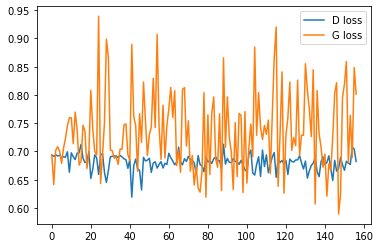

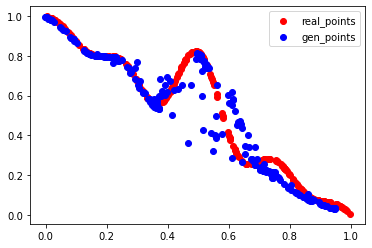

In [ ]:
red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


for epoch in range(n_epochs):
    for i, points in enumerate(train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0) #(B,1) -- столбец-лейблов 1
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0)  #(B,1)  -- столбец-лейблов 0

        real_points = points.type(torch.FloatTensor) #(B,2) -- реальные данные

        # Генерация шума (B,latent_dim)
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)   #(B,2) -- сгенерированные данные

######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_points)  #(B,1)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_points) #(B,1)

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################

        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))) #(B,latent_dim)

        # Генерируем данные Генератором на основе шума
        gen_points = generator(z)  #(B,2)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_points)  #(B,1)

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)

        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()
                display.clear_output(wait=False)
                # clear_output(wait=False)

                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')


                d_loss = d_loss.detach()  #новый тензор без градиента
                g_loss = g_loss.detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()

                x_real, y_real = (real_points.detach()).T
                plt.scatter(x_real, y_real, color='red', label='real_points')
                x_gen, y_gen = (gen_points.detach()).T
                plt.scatter(x_gen, y_gen, color='blue', label='gen_points')
                plt.legend()
                plt.show()